# Get Genna's CESM satellite emulator output for use by TE (regrid to JRA mesh)
# This was run on NCAR's derecho where all the model output is stored.

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import numpy as np
import random
import xesmf as xesmf
from shapely.geometry import Point
import geopandas as gpd
import os
from netCDF4 import Dataset, MFDataset
from tqdm import tqdm

In [2]:
#---
# pick a random JRA file to get lat/lon info
#---

lr_grid = xr.open_dataset('/glade/p/cesmdata/cseg/inputdata/ocn/jra55/v1.5_noleap/JRA.v1.5.v_10.TL319.2021.220505.nc',\
                          decode_times=False)['v_10'].isel(time=0)
lr_grid = lr_grid.drop_vars('time')
lon_jra = lr_grid['longitude'].values
lat_jra = lr_grid['latitude'].values
#lr_grid


In [3]:
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

def apply_prob(x, choices = [True, False]): 
    '''
    Generate a binary output of having clear sky vs. cloud based on probability of the entire grid cell being cloudy. 
    For example, if a grid cell has 70% cloud cover, there will be a 30% chance of getting a good reading from the satellite sensor somewhere over that region. 
    
    True = masked (cloud-obscured, cloud_prob = 1)
    False = clear (no clouds, cloud_prob = 0)
    
    Input 
    ------
    x: float
        Probability that the outcome is True (cloud-obscured)
    
    Returns
    -------
    mask : bool
    '''
    if x > 1: 
        cloud_prob = 1
    else: 
        cloud_prob = x
    clear_prob = 1 - cloud_prob

    # p is the probability associated with each entry in the 'choices' list
    choice = np.random.choice(choices, 1, replace=False, p=[cloud_prob, clear_prob])
    mask = choice[0] 

    return mask

def apply_prob_mask(ds):
    '''
    Apply the prob_mask function to an xarray Dataset
    
    Parameters
    ----------
    ds : xarray Dataset
        Input dataset. Must have chlos and cloud_prob field, where cloud_prob is the cloud fraction in decimal form. 
    
    Returns 
    -------
    ds_masked : xarray Dataset
        Output dataset with new variable called 'cloud_masked_chlos'. This is a copy of the 'chlos' field with the cloud mask applied.
        The mask assigns values of np.nan. 
    '''
    
    df = ds[['chlos', 'cloud_prob']].to_dataframe()
    df['mask'] = df.cloud_prob.dropna().apply(lambda x: apply_prob(x))
    # If mask == False, keep chlorophyll data, otherwise assign np.nan
    df['cloud_masked_chlos'] = df['chlos'].where(df['mask'] == False)
    ds_new = df.to_xarray()
    ds_new = ds_new.transpose()
    
    return ds_new, df

def plot_test_SO(so_masked):
    
    point = Point(0, -87)
    p = gpd.GeoSeries(point)
    fig, axs = plt.subplots(ncols=3, subplot_kw={'projection': ccrs.SouthPolarStereo()}, # ccrs.PlateCarree()
                                figsize=(17,5))
    axs=axs.flatten()
        
    im1 = axs[0].pcolormesh(so_masked.longitude,so_masked.latitude,so_masked.cloud_prob.transpose(),
                      transform = ccrs.PlateCarree(),
                      cmap='Blues_r',vmin = 0, vmax = 1)#,shading='auto')
    axs[0].set_title('Cloud Cover', fontsize=18)
        
    im2 = axs[1].pcolormesh(so_masked.longitude,so_masked.latitude,np.log(so_masked.chlos).transpose(),
                      transform = ccrs.PlateCarree(),
                      cmap='viridis', vmin = -2, vmax = 1,shading='auto')
    axs[1].set_title('Full-Field Chlorophyll', fontsize=18)
        
    axs[2].pcolormesh(so_masked.longitude,so_masked.latitude,np.log(so_masked.cloud_masked_chlos).transpose(),
                      transform = ccrs.PlateCarree(),
                      cmap='viridis', vmin = -2, vmax = 1,shading='auto')
    axs[2].set_title('Masked Chlorophyll', fontsize=18)
        
    for i in [0,1,2]:
        axs[i].coastlines(color = 'black', linewidth = 2)
        axs[i].add_feature(cartopy.feature.OCEAN, color='white')
        axs[i].add_feature(cartopy.feature.LAND, color='grey')
        axs[i].set_extent([-180,180,-90,-35], crs=ccrs.PlateCarree())
            
    # [left, bottom, width, height]
    cbar_ax = fig.add_axes([0, 0, 0.03,1])
    cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('percent cloud fraction',
                                   #labelpad=10, 
                                   fontsize=20)
        
    cbar_ax = fig.add_axes([1, 0, 0.03, 1])
    cbar=fig.colorbar(im2, cax=cbar_ax,orientation='vertical')
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('natural log of chl-a (mg/m^3)',
                                   #labelpad=10, 
                                   fontsize=20)
    plt.tight_layout()



Load year 2000
min/max chlorophyll PFT1 [mg chl m-3]: -0.22427788 7.115171
min/max chlorophyll PFT2 [mg chl m-3]: -0.9433501 21.720041
min/max chlorophyll PFT3 [mg chl m-3]: -0.00048287594 0.023822414
min/max chlorophyll [mg chl m-3]: -0.71378756 21.727598
min/max cloud cover [%] (before interpolation): 0.0 100.00001
min/max cloud cover [%]: 0.0 100.00001
1.0000001
process one day for test plot...


/glade/work/cnissen/conda-envs/myenv/lib/python3.9/site-packages/xarray/core/computation.py:825: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/glade/work/cnissen/conda-envs/myenv/lib/python3.9/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/glade/derecho/scratch/cnissen/tmp/ipykernel_21018/829565832.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


done


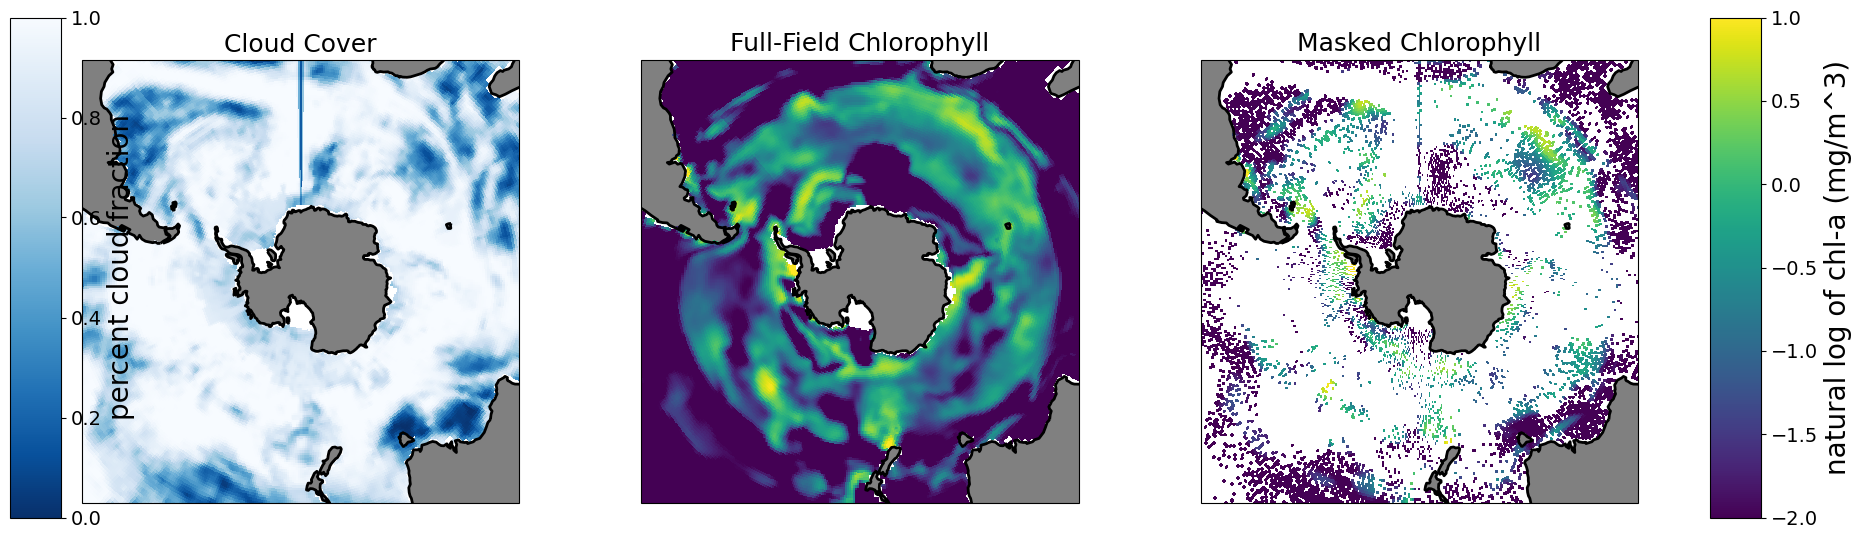

In [6]:
#-----
# loop over all years, calculated cloud-masked chl, and save as netcdf file 
#-----

savepath = '/glade/work/cnissen/CESM_cloud_masked_chl_regridded/'
save_netcdf = False
plot_test = True

path1 = '/glade/derecho/scratch/gclow/archive/g.e22.GOMIPECOIAF_JRA.TL319_g17_sst/ocn/hist/'
var1  = 'spChl_SURF'
var2  = 'diatChl_SURF'
var3  = 'diazChl_SURF'

var_save1   = 'totChl_masked'
var_save2   = 'cloud_cover'
var_description1 = 'masked surface chlorophyll from satellite emulator in mg m-3'
var_description2 = 'ISCCP cloud cover used to mask total chlorophyll field'
fv = -999

savepath = '/glade/work/cnissen/CESM_totChl_emulator_regridded/'
# check existence of paths
if not os.path.exists(savepath):
    print ('Created '+savepath)
    os.makedirs(savepath)

year_list = np.arange(1984,2018+1,1)

# 1978-1983 look weird -> climatology only! don't use these years!

for yy in range(16,17):#6,10):#,len(year_list)):
    print('Load year',year_list[yy])

    # load PFT data and combine to get total chlorophyll
    file_chl = 'g.e22.GOMIPECOIAF_JRA.TL319_g17_sst.pop.h.ecosys.nday1.'+str(year_list[yy])+'-01-01.nc'
    #print('load PFT1...')
    ff1 = xr.open_dataset(path1+file_chl)[var1] #.isel(z_t=0)
    ff1 = ff1.rename({'TLONG': 'longitude','TLAT': 'latitude'})
    ff1 = ff1.drop_vars('ULONG')
    ff1 = ff1.drop_vars('ULAT')
    ff1 = ff1.drop_vars('time')
    #print('load PFT2...')
    ff2 = xr.open_dataset(path1+file_chl)[var2] 
    ff2 = ff2.rename({'TLONG': 'longitude','TLAT': 'latitude'})
    ff2 = ff2.drop_vars('ULONG')
    ff2 = ff2.drop_vars('ULAT')
    ff2 = ff2.drop_vars('time')
    #print('load PFT3...')
    ff3 = xr.open_dataset(path1+file_chl)[var3] 
    ff3 = ff3.rename({'TLONG': 'longitude','TLAT': 'latitude'})
    ff3 = ff3.drop_vars('ULONG')
    ff3 = ff3.drop_vars('ULAT')
    ff3 = ff3.drop_vars('time')
    # first add fields and then interpolate
    ff_chl = ff1+ff2+ff3
    print('min/max chlorophyll PFT1 [mg chl m-3]:',np.nanmin(ff1),np.nanmax(ff1))
    print('min/max chlorophyll PFT2 [mg chl m-3]:',np.nanmin(ff2),np.nanmax(ff2))
    print('min/max chlorophyll PFT3 [mg chl m-3]:',np.nanmin(ff3),np.nanmax(ff3))
    print('min/max chlorophyll [mg chl m-3]:',np.nanmin(ff_chl),np.nanmax(ff_chl))
    ff1.close()
    ff2.close()
    ff3.close()
    # create mapping file
    regridder_jra = xesmf.Regridder(ff_chl, lr_grid, 'bilinear') 
    # regrid field
    ff_chl_regr = regridder_jra(ff_chl)
    # get rid of white line!
    ff_chl_regr[:,:,568] = ff_chl_regr[:,:,567]
    ff_chl_regr[:,:,569] = ff_chl_regr[:,:,570]
    
    # cloud fraction
    #print('load cloud variables...')
    file_cloud = 'g.e22.GOMIPECOIAF_JRA.TL319_g17_sst.pop.h.ecosys.nday2.'+str(year_list[yy])+'-01-01.nc'
    ff1 = xr.open_dataset(path1+file_cloud)['cloudfrac_isccp']#.isel(z_t=0)
    ff1 = ff1.rename({'TLONG': 'longitude','TLAT': 'latitude'})
    ff1 = ff1.drop_vars('ULONG')
    ff1 = ff1.drop_vars('ULAT')
    ff1 = ff1.drop_vars('time')
    # weights
    ff2 = xr.open_dataset(path1+file_cloud)['cloudfrac_isccp_wgt']#.isel(z_t=0)
    ff2 = ff2.rename({'TLONG': 'longitude','TLAT': 'latitude'})
    ff2 = ff2.drop_vars('ULONG')
    ff2 = ff2.drop_vars('ULAT')
    ff2 = ff2.drop_vars('time')
    # first divide fields and then interpolate
    ff_cloud = ff1/ff2
    print('min/max cloud cover [%] (before interpolation):',np.nanmin(ff_cloud),np.nanmax(ff_cloud))
    ff1.close()
    ff2.close()
    # create mapping file
    regridder_jra = xesmf.Regridder(ff_cloud, lr_grid, 'bilinear') 
    # regrid field
    ff_cloud_regr = regridder_jra(ff_cloud)
    print('min/max cloud cover [%]:',np.nanmin(ff_cloud_regr),np.nanmax(ff_cloud_regr))
    ff_cloud_regr = ff_cloud_regr/100 # convert to 0-1
    # set zeros to NaN (over Antarctica and Greenland)
    ff_cloud_regr = ff_cloud_regr.where(ff_cloud_regr != 0.) 
    # get rid of white line!
    ff_cloud_regr[:,:,568] = ff_cloud_regr[:,:,567]
    ff_cloud_regr[:,:,569] = ff_cloud_regr[:,:,570]

    # merge variables into one dataset
    chla_clouds = xr.merge([ff_chl_regr.to_dataset(name='chlos'), ff_cloud_regr.to_dataset(name='cloud_prob')])
    #print(chla_clouds)
    print(np.nanmax(chla_clouds.cloud_prob))

    # loop over each day, apply masking and save as netcdf!
    if save_netcdf:
        for tt in tqdm(range(0,365)):
            so_unmasked = chla_clouds.isel(time=tt)
            so_masked, so_masked_df = apply_prob_mask(so_unmasked)
            netcdf_name = 'totChl_emulator_JRA_grid_'+str(year_list[yy])+'-01-01.nc'
            if not os.path.exists(savepath+netcdf_name):
                print('Create file '+savepath+netcdf_name)
                w_nc_fid = Dataset(savepath+netcdf_name, 'w', format='NETCDF4_CLASSIC')
                w_nc_fid.contact = 'Cara Nissen, cara.nissen@colorado.edu'
                w_nc_fid.source_file1 = path1+file_chl
                w_nc_fid.source_file2 = path1+file_cloud
                w_nc_fid.script      = '/glade/u/home/cnissen/scripts/save_masked_chl_from_simulator_as_netcdf.ipynb'
                # create dimension & variable
                w_nc_fid.createDimension('time', ff_cloud_regr.shape[0]) 
                w_nc_fid.createDimension('latitude', ff_cloud_regr.shape[1]) 
                w_nc_fid.createDimension('longitude', ff_cloud_regr.shape[2]) 
                w_nc_var1 = w_nc_fid.createVariable(var_save1, 'f4',('time','latitude','longitude'),fill_value=fv)
                w_nc_var1.description = var_description1
                w_nc_var1.units = 'mg chl m-3'
                w_nc_var1 = w_nc_fid.createVariable(var_save2, 'f4',('time','latitude','longitude'),fill_value=fv)
                w_nc_var1.description = var_description2
                w_nc_var1.units = 'n.d'
                w_nc_var1 = w_nc_fid.createVariable('latitude', 'f4',('latitude'),fill_value=fv)
                w_nc_var1.description = 'Latitude'
                w_nc_var1.units = 'deg N'
                w_nc_var1 = w_nc_fid.createVariable('longitude', 'f4',('longitude'),fill_value=fv)
                w_nc_var1.description = 'Longitude (0:360)'
                w_nc_var1.units = 'deg E'
                w_nc_fid.variables['latitude'][:] = lat_jra
                w_nc_fid.variables['longitude'][:] = lon_jra
                w_nc_fid.close()

            data_to_save1 = so_masked.cloud_masked_chlos.values
            data_to_save2 = so_masked.cloud_prob.values
            
            data_to_save1[np.isnan(data_to_save1)] = fv
            data_to_save1[data_to_save1==0] = fv
            data_to_save2[np.isnan(data_to_save2)] = fv
            data_to_save2[data_to_save2==0] = fv

            w_nc_fid = Dataset(savepath+netcdf_name, 'r+', format='NETCDF4_CLASSIC') 
            w_nc_fid.variables[var_save1][tt,:,:] = data_to_save1.transpose()
            w_nc_fid.variables[var_save2][tt,:,:] = data_to_save2.transpose()
            w_nc_fid.close()             

    if plot_test:
        # apply masking to get masked chlorophyll
        print('process one day for test plot...')
        day_1 = chla_clouds.isel(time=364)
        so_unmasked = day_1.where(day_1.latitude<90, drop=True)
        so_masked, so_masked_df = apply_prob_mask(so_unmasked)
        # call SO plotting function 
        plot_test_SO(so_masked)
        
print('done')


In [ ]:

fig, axs = plt.subplots(ncols=3,figsize=(19,3))
# clouds
mm=axs[0].pcolor(so_masked.cloud_prob.transpose(),cmap='Blues_r')
plt.colorbar(mm,ax=axs[0])
# full chl field
mm=axs[1].pcolor(np.log(so_masked.chlos).transpose(),cmap='viridis', vmin = -2, vmax = 1)
plt.colorbar(mm,ax=axs[1])
# masked chl field
mm=axs[2].pcolor(np.log(so_masked.cloud_masked_chlos).transpose(),cmap='viridis', vmin = -2, vmax = 1)
plt.colorbar(mm,ax=axs[2])
plt.show()
